In [1]:
%reset -f

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def BS_Call(S, σ, r, K, T):
    d1 = (np.log(S/K)+(r+0.5*np.power(σ,2))*T)/(σ*np.power(T,0.5)) 
    d2 = d1 - σ*np.power(T,0.5)
    return norm.cdf(d1)*S - norm.cdf(d2)*K*np.exp(-r*T)

Error of ATM strike option =  -0.001210048503004657
Wall time: 3.2 s


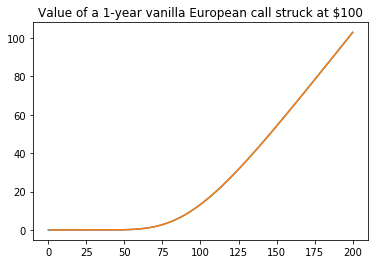

In [2]:
%%time
%matplotlib inline

# Nx = asset price steps
def Explicit_FDM_Loops(σ, r, K, T, Nx, Nt):  
    xs = np.linspace(0, 2*K, Nx+1) 
    Δx = xs[1]-xs[0]
    Δt = T / Nt 
    # Initial Condition
    V = np.maximum(xs-K, 0) 

    for k in range(Nt):
        # Temp store for current V values
        W = list(V)
        # Loop for all points except boundaries
        for i in range(1, Nx):
            # Central difference for both Delta and Gamma
            fx = (W[i + 1] - W[i - 1]) / (2.*Δx) 
            fxx = (W[i + 1] - 2. * W[i] + W[i - 1]) / Δx**2            
            # Black-Scholes equation
            ft = 0.5 * σ**2 * xs[i]**2 * fxx + r*xs[i]*fx - r*W[i]      
            # Compute V in next timestep
            V[i] = W[i] + Δt * ft
            
        # Boundary condition at small asset price
        V[0] = W[0] * (1. - r * Δt) 
        # Boundary condition at large asset price
        V[-1] = 2. * V[-2] - V[-3]
    
    return V, xs

# Input parameters
σ = 0.3; r = 0.03; K = 100; T = 1; Nx = 200; Nt = 4000

V, xs = Explicit_FDM_Loops(σ, r, K, T, Nx, Nt)
plt.plot(xs, V, xs[1:], BS_Call(xs[1:], σ, r, K, T)) # comparing FDM price curve with BS price curve
plt.title("Value of a 1-year vanilla European call struck at $100")
print('Error of ATM strike option = ', (V[int(Nx/2)] - BS_Call(K, σ, r, K, T)))

Error of ATM strike option =  2.8947977918145465e+190
Wall time: 63.9 ms


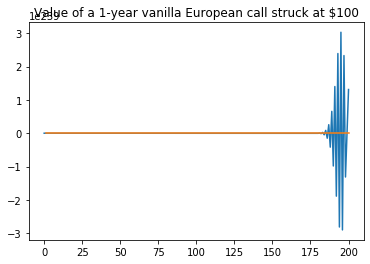

In [3]:
%%time
%matplotlib inline

from scipy.sparse import diags

def Explicit_FDM_Matrix(σ, r, K, T, Nx, Nt):                                      
    xs = np.linspace(0, 2*K, Nx+1)  # creates array of equally spaced points along domain of x in [0,2*K]
    Δx = xs[1]-xs[0]                # step size of x 
    Δt = T / Nt                     # step size of tau
    # initial condition of option
    V = np.maximum(xs-K, 0)         

    # Set up matrix diagonals for d0 - main diagonal, d1 - super diagonal, dm1 - sub diagonal
    d0 = 1 - σ**2 * np.power(xs,2)*Δt/Δx**2 - r*Δt
    d1 = 0.5*(r*xs[0:-1]*Δt/Δx + σ**2 * np.power(xs[0:-1],2)*Δt/Δx**2) # i-th element corresponds to x(i)
    dm1 = 0.5*(σ**2 * np.power(xs[1:],2)*Δt/Δx**2 - r*xs[1:]*Δt/Δx)    # i-th element corresponeds to x(i+1)
    
    # Boundary condition for small asset price
    d0[0] = (1 - r * Δt) 
    d1[0] = 0
    
    # Construct the matrix
    A = diags([dm1,d0,d1], [-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    
    for t in range(Nt):
        V = A.dot(V)
        # Boundary condition for large asset price
        V[-1] = 2.*V[-2] - V[-3] 
    
    return V, xs

# Input parameters
σ = 0.3; r = 0.03; K = 100; T = 1; Nx = 200; Nt = 3000

V, xs = Explicit_FDM_Matrix(σ, r, K, T, Nx, Nt)
plt.plot(xs, V, xs[1:], BS_Call(xs[1:], σ, r, K, T)) # comparing FDM price curve with BS price curve
plt.title("Value of a 1-year vanilla European call struck at $100")
print('Error of ATM strike option = ', (V[int(Nx/2)] - BS_Call(K, σ, r, K, T)))

Error of ATM strike option =  -0.0012100485049391096
Wall time: 47.4 ms


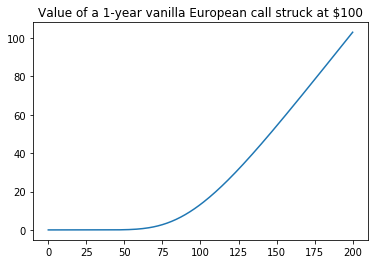

In [9]:
%%time
%matplotlib inline

def Explicit_FDM_Matrix(σ, r, K, T, Nx, Nt=None):  
    xs = np.linspace(0, 2*K, Nx+1) 
    Δx = xs[1]-xs[0]
    if Nt is None:
        Δt = 0.9 / σ**2 / Nx**2   # stability condition     
        Nt = int(T/Δt)            # ensure that Nt is an integer for the time loop
    else:
        Δt = T/Nt
    # initial condition of option
    V = np.maximum(xs-K, 0) 

    # set up matrix diagonals
    d0 = 1 - σ**2 * np.power(xs,2)*Δt/Δx**2 - r*Δt
    d1 = 0.5*(r*xs[0:-1]*Δt/Δx + σ**2 * np.power(xs[0:-1],2)*Δt/Δx**2) # i-th element corresponds to x(i)
    dm1 = 0.5*(σ**2 * np.power(xs[1:],2)*Δt/Δx**2 - r*xs[1:]*Δt/Δx)    # i-th element corresponeds to x(i+1)
    
    # boundary condition for small asset price
    d0[0] = (1 - r * Δt) 
    d1[0] = 0
    
    # construct the matrix
    A = diags([dm1,d0,d1], [-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    
    for t in range(Nt):
        V = A.dot(V)
        V[-1] = 2.*V[-2] - V[-3] # boundary condition for large asset price
    
    return V, xs

# input parameters
σ = 0.3; r = 0.03; K = 100; T = 1; Nx = 200

V, xs = Explicit_FDM_Matrix(σ, r, K, T, Nx)
plt.plot(xs, V)
plt.title("Value of a 1-year vanilla European call struck at $100")
print('Error of ATM strike option = ', (V[int(Nx/2)] - BS_Call(K, σ, r, K, T)))

Error of ATM strike option =  -0.010177804241074284
Wall time: 120 ms


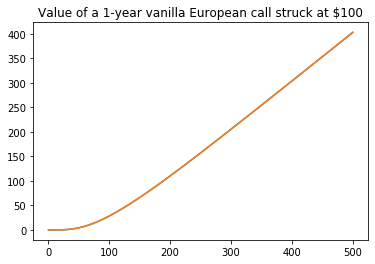

In [4]:
%%time
%matplotlib inline

from scipy.sparse.linalg import spsolve

def Implicit_FDM(σ, r, K, T, Nx, Nt, m=2):      
    xs = np.linspace(0, m*K, Nx+1) 
    Δx = xs[1]-xs[0]
    Δt = T / Nt 
    # initial Condition
    V = np.maximum(xs-K, 0) 

    # Set up matrix diagonals
    d0 = 1 + σ**2 * np.power(xs,2)*Δt/Δx**2 + r*Δt
    d1 = -0.5*(r*xs[0:-1]*Δt/Δx + σ**2 * np.power(xs[0:-1],2)*Δt/Δx**2)
    dm1 = 0.5*(r*xs[1:]*Δt/Δx - σ**2 * np.power(xs[1:],2)*Δt/Δx**2)
    dm2 = np.zeros(Nx-1)
    
    # Boundary condition for small asset price
    d0[0] = 1/(1 - r * Δt) 
    d1[0] = 0
    # Boundary condition for large asset price
    d0[-1] = 1
    dm1[-1] = -2
    dm2[-1] = 1
    
    # Construct the matrix
    A = diags([dm2,dm1,d0,d1], [-2,-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    A = A.tocsr() # solver is more efficient with csc or csr format
    
    for t in range(Nt):
        V[-1] = 0 # Boundary condition for large asset price
        V = spsolve(A,V)
        
    return V, xs

# Input parameters
σ = 0.7; r = 0.03; K = 100; T = 1; Nx = 500; Nt = 400; m = 5

V, xs = Implicit_FDM(σ, r, K, T, Nx, Nt, m)
plt.plot(xs, V, xs[1:], BS_Call(xs[1:], σ, r, K, T)) # comparing FDM price curve with BS price curve
plt.title("Value of a 1-year vanilla European call struck at $100")
print('Error of ATM strike option = ', (V[int(Nx/m)] - BS_Call(K, σ, r, K, T)))

In [5]:
# Find a suitable bound on the high boundary of x by using the inverse CDF of normal distribution

import math
from scipy.stats import norm

σ = 0.7; r = 0.03; S = 100.; T = 1.

pct = 0.99

S_max = S*math.exp((r - 0.5*σ**2)*T + σ*norm.ppf(pct))

print(S_max)

411.0084187309244


Error of ATM strike option =  -0.0016020739713393795
Wall time: 94.7 ms


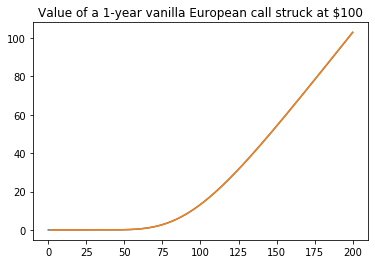

In [6]:
%%time
%matplotlib inline

def Crank_Nicolson_FDM(σ, r, K, T, Nx, Nt):  
    xs = np.linspace(0, 2*K, Nx+1) 
    Δx = xs[1]-xs[0]
    Δt = T / Nt 
    V = np.maximum(xs-K, 0) # initial Condition

    # Set up RHS matrix diagonals
    d0 = 1 - 0.5*(σ**2 * np.power(xs,2)*Δt/Δx**2 + r*Δt)
    d1 = 0.25*(r*xs[0:-1]*Δt/Δx + σ**2 * np.power(xs[0:-1],2)*Δt/Δx**2)
    dm1 = 0.25*(σ**2 * np.power(xs[1:],2)*Δt/Δx**2 - r*xs[1:]*Δt/Δx)
    
    # Boundary condition for small asset price
    d0[0] = 1
    d1[0] = 0
    
    # Boundary condition for large asset price
    d0[-1] = 0
    dm1[-1] = 0
    
    # Construct RHS matrix
    B = diags([dm1,d0,d1], [-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    
    # Set up LHS matrix diagonals
    d0 = 2-d0
    d1 = -d1
    dm1 = -dm1
    dm2 = np.zeros(Nx-1) 
    
    # Boundary condition for small asset price
    d0[0] = 1/(1 - r * Δt) 
    d1[0] = 0
    
    # Boundary condition for large asset price
    d0[-1] = 1
    dm1[-1] = -2
    dm2[-1] = 1
    
    # Construct LHS matrix
    A = diags([dm2,dm1,d0,d1], [-2,-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    A = A.tocsr()    
    
    for t in range(Nt):
        V = B.dot(V)
        V = spsolve(A,V)
        
    return V, xs

# Input parameters
σ = 0.3; r = 0.03; K = 100; T = 1; Nx = 200; Nt = 400

V, xs = Crank_Nicolson_FDM(σ, r, K, T, Nx, Nt)
plt.plot(xs, V, xs[1:], BS_Call(xs[1:], σ, r, K, T)) # comparing FDM price curve with BS price curve
plt.title("Value of a 1-year vanilla European call struck at $100")
print('Error of ATM strike option = ', (V[int(Nx/2)] - BS_Call(K, σ, r, K, T)))

In [7]:
def BS_Put(S, σ, r, K, T):
    d1 = (np.log(S/K)+(r+0.5*np.power(σ,2))*T)/(σ*np.power(T,0.5))
    d2 = d1 - σ*np.power(T,0.5)
    return norm.cdf(-d2)*K*np.exp(-r*T) - norm.cdf(-d1)*S 

Error of option price =  -0.0007811281208027765
Wall time: 107 ms


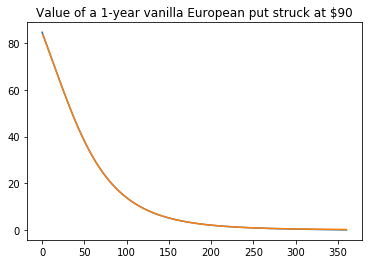

In [8]:
%%time
%matplotlib inline

def Crank_Nicolson_FDM(σ, r, K, T, Nx, Nt, m=2):  
    xs = np.linspace(0, m*K, Nx+1) 
    Δx = xs[1]-xs[0]
    Δt = T / Nt 
    V = np.maximum(K-xs, 0) # initial Condition

    # Set up RHS matrix diagonals
    d0 = 1 - 0.5*(σ**2 * np.power(xs,2)*Δt/Δx**2 + r*Δt)
    d1 = 0.25*(r*xs[0:-1]*Δt/Δx + σ**2 * np.power(xs[0:-1],2)*Δt/Δx**2)
    dm1 = 0.25*(σ**2 * np.power(xs[1:],2)*Δt/Δx**2 - r*xs[1:]*Δt/Δx)
    
    # Boundary condition for small asset price
    d0[0] = 1
    d1[0] = 0
    
    # Boundary condition for large asset price
    d0[-1] = 0
    dm1[-1] = 0
    
    # Construct RHS matrix
    B = diags([dm1,d0,d1], [-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    
    # Set up LHS matrix diagonals
    d0 = 2-d0
    d1 = -d1
    dm1 = -dm1
    dm2 = np.zeros(Nx-1) 
    
    # Boundary condition for small asset price
    d0[0] = 1/(1 - r * Δt) 
    d1[0] = 0
    
    # Boundary condition for large asset price
    d0[-1] = 1
    dm1[-1] = -2
    dm2[-1] = 1
    
    # Construct LHS matrix
    A = diags([dm2,dm1,d0,d1], [-2,-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    A = A.tocsr()    
    
    for t in range(Nt):
        V = B.dot(V)
        V = spsolve(A,V)
        
    return V, xs

# Input parameters
σ = 0.4; r = 0.03; K = 90; T = 2; Nx = 360; Nt = 400; m = 4;

V, xs = Crank_Nicolson_FDM(σ, r, K, T, Nx, Nt, m)
plt.plot(xs, V, xs[1:], BS_Put(xs[1:], σ, r, K, T)) # comparing FDM price curve with BS price curve

x0 = 100

plt.title("Value of a 1-year vanilla European put struck at $90")
print('Error of option price = ', (V[int(x0*Nx/(m*K))] - BS_Put(x0, σ, r, K, T)))